In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [10]:
df = pd.read_csv('AfterEDA.csv', sep='\t', index_col=0)

In [11]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split data into train/val/test
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [14]:
# Normalize data using training mean and std
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


C:\Users\Artem\AppData\Local\Temp\ipykernel_23684\3325779676.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.columns, rotation=90)


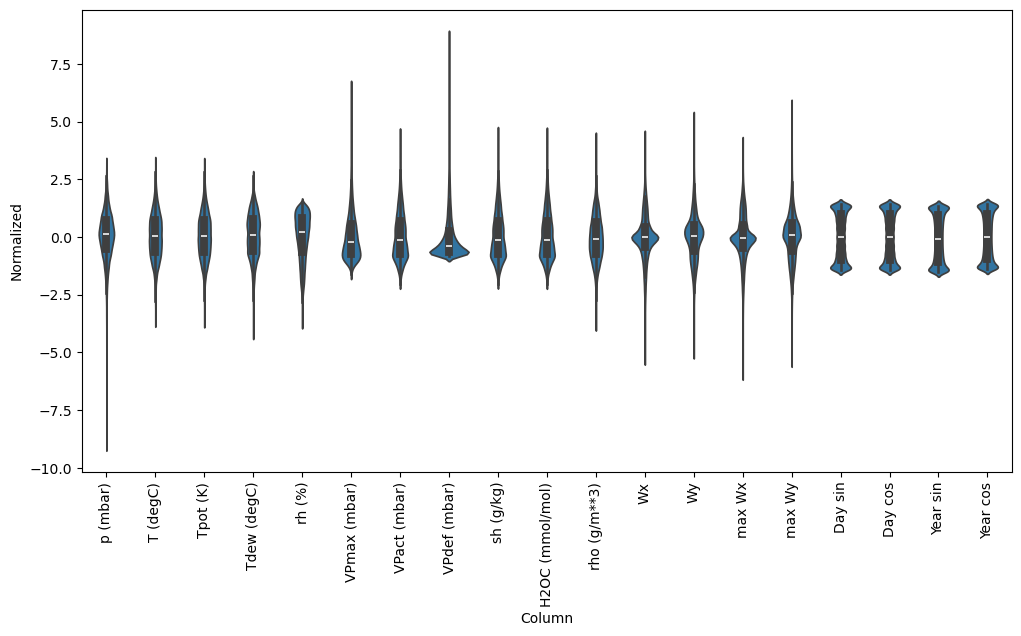

In [22]:
# Generate a dataframe for violin plot and make the plot
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.columns, rotation=90)

In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']